In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from glob import glob

# Read preds

## Train

In [21]:
TARGET = 'y'
y = pd.read_csv('../data/train.csv')['y']

In [22]:
df_train_preds = pd.DataFrame()

for f in glob("../output/mario/train*.csv") + glob("../output/hugo/train*.csv"):
    prefix = f.split("_")[-1]
    prefix = prefix.replace(".csv", "")    
    df_train_preds[f"{prefix}"] = pd.read_csv(f)['y']
    df_train_preds[f"{prefix}_p"] = pd.read_csv(f)['predicted']
df_train_preds.head()

,nn-v1,nn-v1_p,lgbm-v3,lgbm-v3_p,lgbm-v2,lgbm-v2_p,lgbm-v5,lgbm-v5_p,magic-v1,magic-v1_p,nn-aug-v1,nn-aug-v1_p,lgbm-v1,lgbm-v1_p,preds,preds_p
0,0.999746,1,0.970255,1,0.967068,1,0.970255,1,0.754668,1,0.935343,1,0.898213,1,0.958938,1
1,0.017679,0,0.330973,0,0.461947,0,0.305133,0,0.080802,0,0.016357,0,0.070971,0,0.211756,0
2,0.297728,1,0.707507,0,0.762748,0,0.764164,0,0.020948,0,0.261597,0,0.238242,0,0.823717,0
3,0.023954,0,0.500531,0,0.624779,0,0.516814,0,0.059005,0,0.098270,0,0.128486,0,0.583363,0
4,0.997373,1,0.964248,1,0.976637,1,0.968496,1,0.042712,0,0.964648,1,0.935811,1,0.991504,1


In [23]:
df_train_preds = df_train_preds[[col for col in df_train_preds.columns if 'nn-v1' not in col]]
df_train_preds = df_train_preds[[col for col in df_train_preds.columns if 'preds' not in col]]

In [24]:
df_train_preds.columns

Index(['lgbm-v3', 'lgbm-v3_p', 'lgbm-v2', 'lgbm-v2_p', 'lgbm-v5', 'lgbm-v5_p',
       'magic-v1', 'magic-v1_p', 'nn-aug-v1', 'nn-aug-v1_p', 'lgbm-v1',
       'lgbm-v1_p'],
      dtype='object')

## Test

In [25]:
df_test_preds = pd.DataFrame()

for f in glob("../output/mario/test*.csv") + glob("../output/hugo/test*.csv"):
    prefix = f.split("_")[-1]
    prefix = prefix.replace(".csv", "")    
    df_test_preds[f"{prefix}"] = pd.read_csv(f)['y']
    df_test_preds[f"{prefix}_p"] = pd.read_csv(f)['predicted']
df_test_preds.head()

,nn-v1,nn-v1_p,magic-v1,magic-v1_p,lgbm-v5,lgbm-v5_p,lgbm-v3,lgbm-v3_p,lgbm-v2,lgbm-v2_p,nn-aug-v1,nn-aug-v1_p,lgbm-v1,lgbm-v1_p,preds,preds_p
0,0.993534,1,0.858467,1,0.961611,1,0.974565,1,0.972648,1,0.760760,1,0.908583,1,0.970127,1
1,0.393391,1,0.397818,1,0.868451,1,0.898183,1,0.888628,1,0.637950,1,0.620028,1,0.901128,1
2,0.132986,0,0.101617,0,0.727026,0,0.756021,0,0.767021,0,0.313109,1,0.262384,0,0.756796,0
3,0.038953,0,0.531408,1,0.821234,1,0.795421,0,0.801718,1,0.545096,1,0.339390,1,0.827664,1
4,0.609065,1,0.375882,1,0.802153,1,0.816872,1,0.812227,1,0.561998,1,0.379667,1,0.775660,0


# Testing Stacking

In [26]:
df_sub = pd.read_csv("../data/submission_sample.csv")
df_sub.head()

,id,predicted
0,0,1
1,2,1
2,4,1
3,7,0
4,15,1


In [27]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc

SEED = 1996
FOLDS = 5
TARGET = 'y'

df_train = df_train_preds.copy()
df_train[TARGET] = y

features_to_drop = [TARGET]
features = [ft for ft in df_train.columns if ft not in features_to_drop]

importances = df_train[features].columns.to_frame()
train_preds = df_train[TARGET].to_frame()
train_preds["preds"] = 0

df_sub["predicted"] = 0
df_sub[TARGET] = 0


kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_train, df_train[TARGET])):
    x_train, x_valid = df_train.loc[train_index][features], df_train.loc[valid_index][features]
    y_train, y_valid = df_train.loc[train_index][TARGET], df_train.loc[valid_index][TARGET]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=SEED,
        boosting="gbdt",
        objective="binary",
        max_depth=2
    )
    
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc",
        early_stopping_rounds=1000,
        verbose=0
    )
    
    y_pred = clf.predict_proba(x_valid, num_iteration=clf.best_iteration_)[:, 1]
    y_pred = (pd.Series(y_pred).rank()/len(x_valid)).values
    train_preds.loc[valid_index, "preds"] = y_pred
    
    test_preds = clf.predict_proba(df_test_preds[features], num_iteration=clf.best_iteration_)[:, 1]
    test_preds = (pd.Series(test_preds).rank()/len(test_preds)).values
    df_sub[TARGET] += test_preds/FOLDS
    
    importances[fold] = clf.feature_importances_    
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()

print(f"CV AUC: {roc_auc_score(train_preds[TARGET], train_preds['preds'])}")
# Com preds e cliped
# Fold 1, AUC: 0.8964795580970164
# Fold 2, AUC: 0.893466760026452
# Fold 3, AUC: 0.9039358929474461
# Fold 4, AUC: 0.8951318513675494
# Fold 5, AUC: 0.8882209405501331
# CV AUC: 0.8955418396074458

Fold 1, AUC: 0.8969700859688023
Fold 2, AUC: 0.8925763410744155
Fold 3, AUC: 0.9035461158439335
Fold 4, AUC: 0.8947738134155263
Fold 5, AUC: 0.8886062205202446
CV AUC: 0.895294796914223


In [28]:
importances.mean(axis=1).sort_values()

lgbm-v2_p        0.0
magic-v1_p       0.0
lgbm-v1_p        0.0
nn-aug-v1_p      4.6
lgbm-v3_p        5.4
lgbm-v5_p        7.0
magic-v1        61.4
lgbm-v1        105.8
nn-aug-v1      143.0
lgbm-v2        144.6
lgbm-v3        391.0
lgbm-v5        435.0
dtype: float64

# Opt F1

 99%|█████████▉| 992/1000 [00:29<00:00, 33.95it/s]


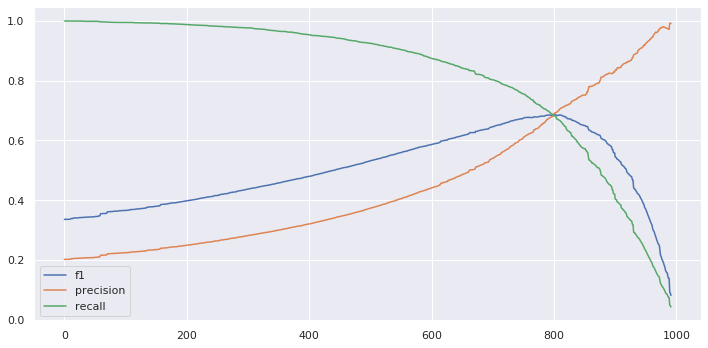

max_f1 [0.802]: 0.6866147308781869


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

f1, precision, recall = [], [], []
max_f1_threshold = -1
max_f1 = -1
for i in tqdm(range(1000)):
    _i = i / 1000.0
    
    y_pred = np.where(train_preds["preds"] > _i, 1, 0)
    
    _precision = precision_score(train_preds[TARGET], y_pred)
    if _precision == 1.0:
        break
    _f1 = f1_score(train_preds[TARGET], y_pred)
    if _f1 > max_f1:
        max_f1 = _f1
        max_f1_threshold = _i
    
    f1.append(_f1)
    precision.append(_precision)
    recall.append(recall_score(train_preds[TARGET], y_pred))
    
plt.figure(figsize=[10, 5])
plt.plot(range(len(f1)), f1, label="f1")
plt.plot(range(len(f1)), precision, label="precision")
plt.plot(range(len(f1)), recall, label="recall")
plt.legend()
plt.tight_layout()
plt.show()

print(f"max_f1 [{max_f1_threshold}]: {max_f1}")
# max_f1 [0.776]: 0.6822942643391521 0.6857142857142858

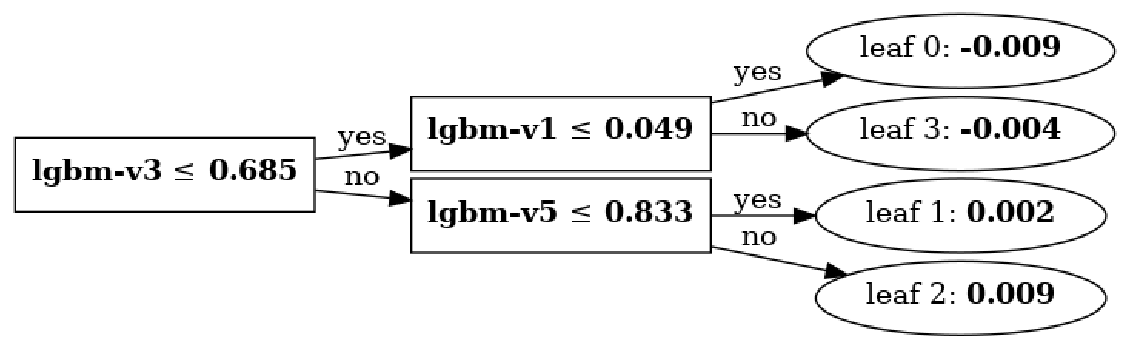

In [30]:
lgb.plot_tree(clf, figsize=(20, 22), tree_index=100)

In [31]:
VERSION = 'stk-v3'
print(f"VERSION ::: {VERSION}")

VERSION ::: stk-v3


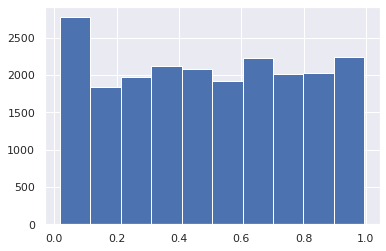

In [32]:
df_sub[TARGET].hist()

In [33]:
df_sub["predicted"] = np.where(df_sub[TARGET] > max_f1_threshold, 1, 0)
df_sub.head()

,id,predicted,y
0,0,1,0.969051
1,2,1,0.876217
2,4,0,0.757910
3,7,1,0.802960
4,15,1,0.821276


In [34]:
df_sub[["predicted", "y"]].describe()

,predicted,y
count,21183.000000,21183.000000
mean,0.198225,0.500024
std,0.398672,0.287809
min,0.000000,0.017698
25%,0.000000,0.253708
50%,0.000000,0.497961
75%,0.000000,0.749452
max,1.000000,0.994736


In [35]:
train_preds.columns = ["predicted", "y"]
train_preds["predicted"] = np.where(train_preds["y"] > max_f1_threshold, 1, 0)
train_preds.head()

,predicted,y
0,1,0.972025
1,0,0.349027
2,0,0.744157
3,0,0.481593
4,1,0.973628


In [36]:
train_preds["id"] = pd.read_csv('../data/train.csv')['id']
train_preds = train_preds[["id", "predicted", "y"]]
train_preds.head()

,id,predicted,y
0,1,1,0.972025
1,8,0,0.349027
2,30,0,0.744157
3,43,0,0.481593
4,46,1,0.973628


In [37]:
# train_preds.to_csv(f"../output/mario/train_preds_{VERSION}.csv", index=False)
# df_sub.to_csv(f"../output/mario/test_preds_{VERSION}.csv", index=False)
df_sub.drop("y", axis=1).to_csv(f"../output/mario/sub_{VERSION}.csv", index=False)

# Confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

cm = confusion_matrix(y_true=df_train[TARGET], y_pred=np.where(train_preds[TARGET] > max_f1_threshold, 1, 0), labels=[0, 1])
pd.DataFrame(cm)
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, fmt="g", ax=ax);  #annot=True to annotate cells, ftm="g" to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel("Predicted labels");
# ax.set_ylabel("True labels"); 
# ax.set_title("Confusion Matrix");

,0,1
0,10414,859
1,911,1939
